In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import os
import re
from tqdm import tqdm,tqdm_notebook
from scipy.stats import skew, norm
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler,LabelEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.svm import NuSVR,SVR
from sklearn.metrics import mean_absolute_error,classification_report,confusion_matrix
from collections import defaultdict,Counter
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import CatBoostRegressor
import time
import datetime
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,GridSearchCV,train_test_split,TimeSeriesSplit,RepeatedStratifiedKFold
from sklearn import linear_model
import gc
from bayes_opt import BayesianOptimization
import eli5
import shap
import json
from IPython.display import HTML
import altair as alt
import networkx as nx
from typing import List,Any
from numba import jit
from itertools import product
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [259]:
train=pd.read_csv(os.path.join(os.getcwd(),'data/DS_bowl/train.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/DS_bowl/test.csv'))
train_label=pd.read_csv(os.path.join(os.getcwd(),'data/DS_bowl/train_labels.csv'))
specs=pd.read_csv(os.path.join(os.getcwd(),'data/DS_bowl/specs.csv'))
train_=train.sample(1000000) ## Take random sample of train, which is huge
combine=[train,test]

In [ ]:
def check_missing(df):
    flag=df.isnull().sum().any()
    if flag == True:
        total=df.isnull().sum().sort_values(ascending=False)
        percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing=pd.concat([total,missing],axis=1,keys=['total','percent'])
        
        data_type=[]
        for col in columns:
            dtype=str(df[col].dtype)
            date_type.append(dtype)
        missing['dtype']=date_type
        return missing
    else:
        return False        

# EDA

Text(0.5, 1.0, 'Target Label Count Distribution')

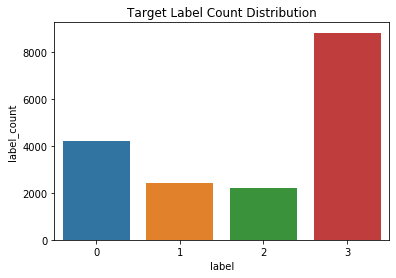

In [46]:
label=train_label.groupby(['accuracy_group']).count()['game_session'].sort_values(ascending=False)
label=pd.DataFrame({'label':label.index,'label_count':label.values})
sns.barplot(x=label['label'],y=label['label_count']).set_title('Target Label Count Distribution')

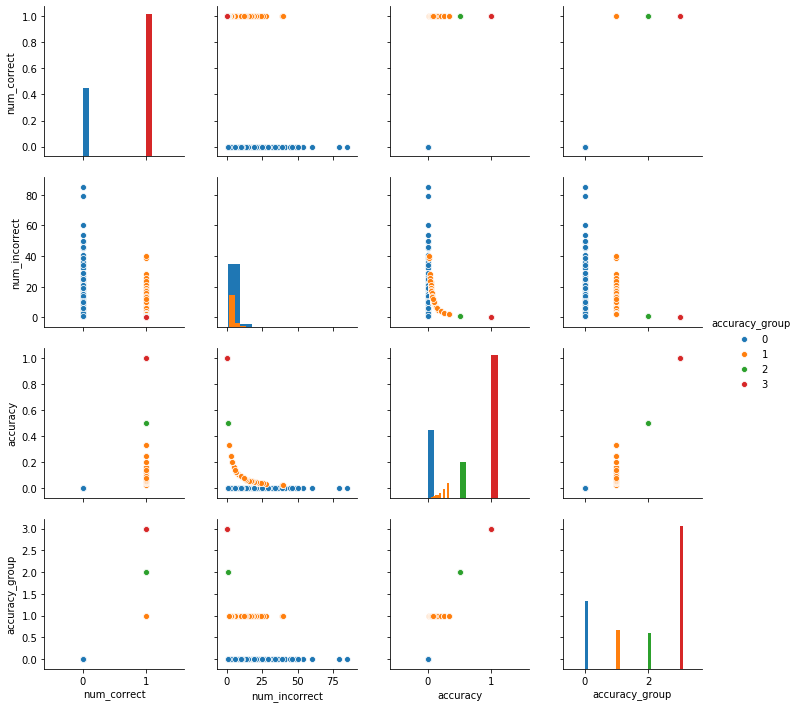

In [68]:
sns.pairplot(train_label,hue="accuracy_group",diag_kind='hist')

In [3]:
for df in tqdm(combine):
    df['date']=df.timestamp.apply(lambda x:pd.to_datetime(x).strftime('%Y-%m-%d'))
    df['hour']=df.timestamp.apply(lambda x:pd.Timestamp(x).hour)
    df['day_name']=df.timestamp.apply(lambda x:pd.Timestamp(x).day_name())

100%|██████████| 2/2 [20:23<00:00, 611.93s/it] 


In [169]:
train['log1p_game_time']=train.game_time.apply(np.log1p)

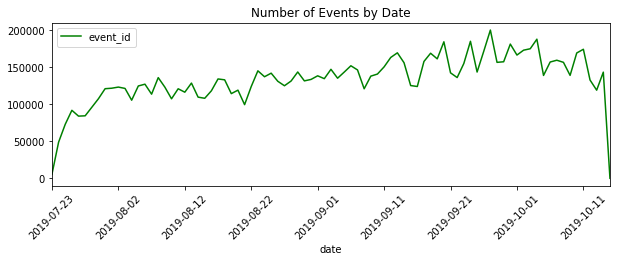

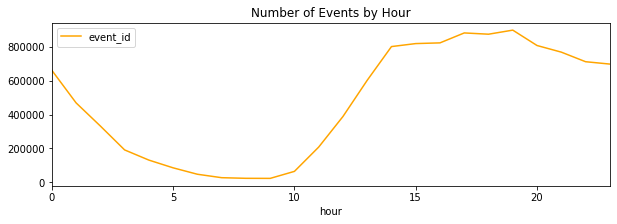

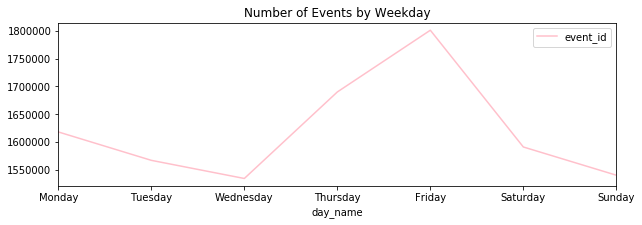

In [40]:
train.groupby(['date']).agg({'event_id':'count'}).plot(figsize=(10,3),color='green',title='Number of Events by Date')
plt.xticks(rotation=45)
train.groupby(['hour']).agg({'event_id':'count'}).plot(figsize=(10,3),color='orange',title='Number of Events by Hour')
train.groupby(['day_name']).agg({'event_id':'count'}).T[['Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday',
                     'Sunday']].T.plot(figsize=(10,3),color='pink',title='Number of Events by Weekday')

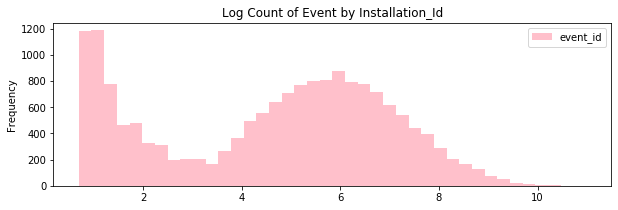

In [86]:
train.groupby(['installation_id']).agg({'event_id':'count'}).apply(np.log1p).plot(figsize=(10,3),kind='hist',bins=40,color='pink',title='Log Count of Event by Installation_Id')

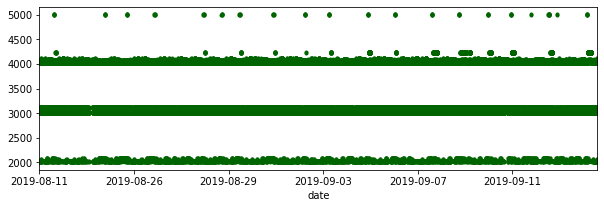

In [99]:
train.loc[train.installation_id=='f1c21eda'].set_index('date')['event_code'].plot(figsize=(10,3),style='.',color='darkgreen')

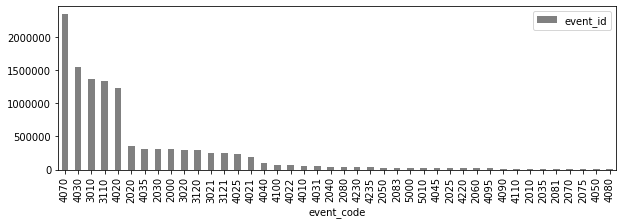

In [107]:
train.groupby(['event_code']).agg({'event_id':'count'}).sort_values(by=['event_id'],ascending=False).plot(color='grey',kind='bar',figsize=(10,3))

Text(0.5, 1.0, 'Log of Game Time')

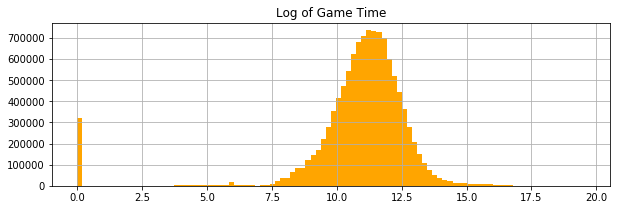

In [115]:
np.log1p(train.game_time).hist(bins=100,color='orange',figsize=(10,3))
plt.title('Log of Game Time')

In [121]:
top10_games=train.groupby(['title']).agg({'event_id':'count','game_time':np.median}).sort_values(by='event_id',ascending=False)[:10]
mask=train.title.isin(top10_games.index)
top10=pd.DataFrame({'title':top10_games.index,'event_counts':top10_games.event_id.values,'median_gametime':top10_games.game_time.values})
top10_median=train.groupby(['title']).agg({'game_time':np.median}).sort_values(by=['game_time'],ascending=False)[:10]
top10_median_gametime=pd.DataFrame({'title':top10_median.index,'medidan_gametime':top10_median.game_time.values})

Text(0.5, 1.0, 'Top 10 Games by Median GameTime')

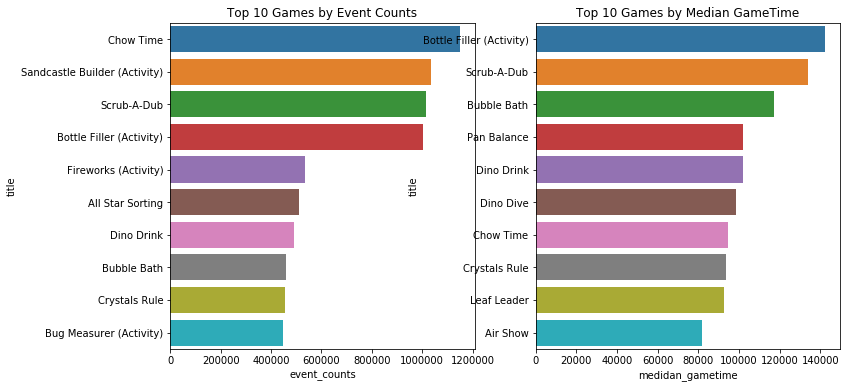

In [158]:
f,axes=plt.subplots(1,2,figsize=(12,6))
sns.barplot(y=top10.title,x=top10.event_counts,ax=axes[0]).set_title('Top 10 Games by Event Counts')
sns.barplot(y=top10_median_gametime.title,x=top10_median_gametime.medidan_gametime,ax=axes[1]).set_title('Top 10 Games by Median GameTime')

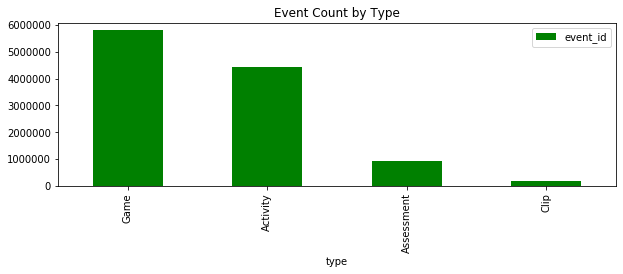

In [165]:
train.groupby(['type']).agg({'event_id':'count'}).sort_values(by=['event_id'],ascending=False).plot(kind='bar',color='green',title='Event Count by Type',figsize=(10,3))

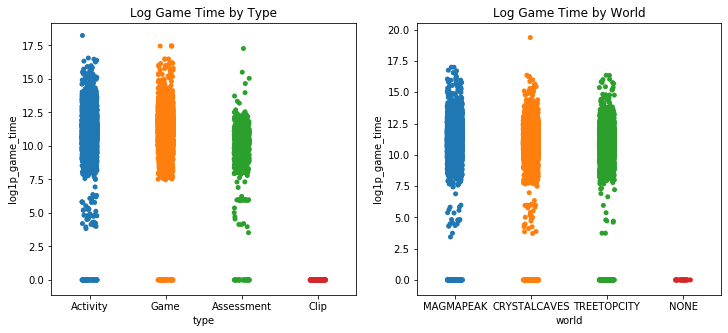

In [193]:
f,axes=plt.subplots(1,2,figsize=(12,5))
sns.catplot(x='type',y='log1p_game_time',data=train.sample(10000),ax=axes[0])
axes[0].set_title('Log Game Time by Type')
plt.close()
sns.catplot(x='world',y='log1p_game_time',data=train.sample(10000),ax=axes[1])
axes[1].set_title('Log Game Time by World')
plt.close()

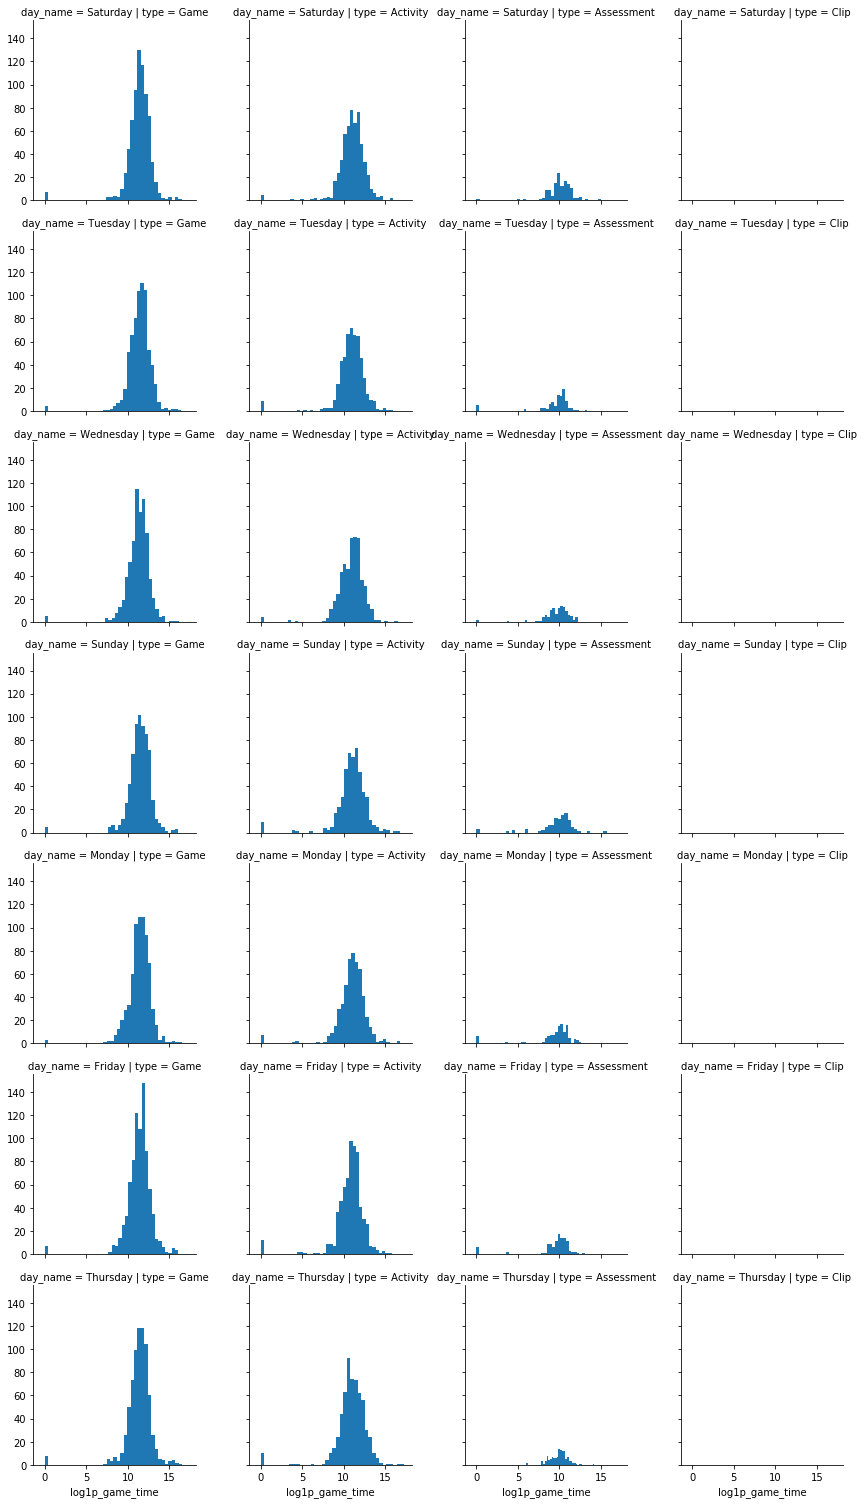

In [215]:
g=sns.FacetGrid(train.sample(10000),col='type',row='day_name')
g.map(plt.hist,'log1p_game_time',bins=40)

In [260]:
keep_id=train.loc[train.type=='Assessment','installation_id'].drop_duplicates()
mask=train.installation_id.isin(keep_id.values)
train=train[mask]
train=train[train.installation_id.isin(train_label.installation_id)]

In [275]:
def get_time(df):
    df['date']=df.timestamp.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
    df['hour']=df.timestamp.apply(lambda x:pd.Timestamp(x).hour)
    df['month']=df.timestamp.apply(lambda x:pd.Timestamp(x).month)
    df['weekday']=df.timestamp.apply(lambda x:pd.Timestamp(x).day_name())
    return df
train=get_time(train)

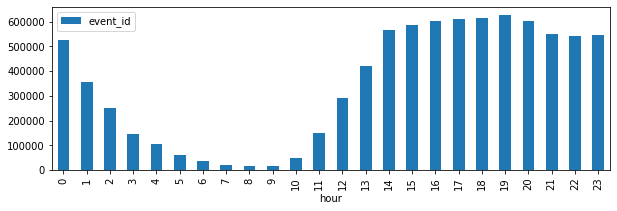

In [286]:
train.groupby(['hour']).agg({'event_id':'count'}).plot(kind='bar',figsize=(10,3))

In [304]:
set(test.installation_id.unique().tolist()).intersection(set(train.installation_id.unique()))

set()

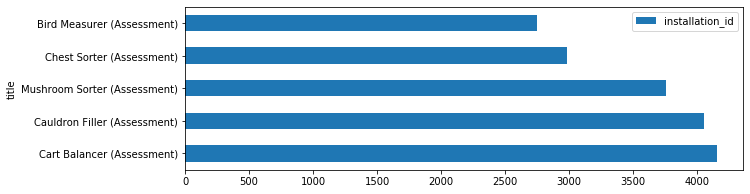

In [311]:
train_label.groupby(['title']).agg({'installation_id':'count'}).sort_values(by=['installation_id'],ascending=False).plot(kind='barh',figsize=(10,3))

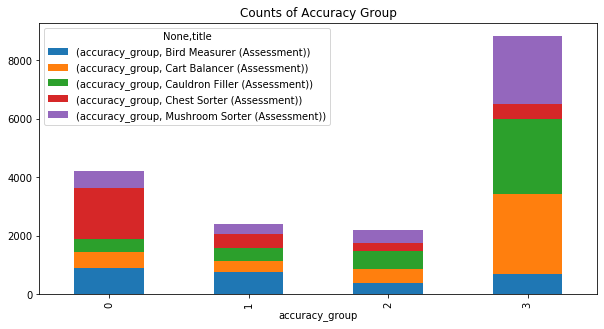

In [326]:
se=train_label.groupby(['title','accuracy_group']).agg({'accuracy_group':'count'}).unstack('title')
se.plot(kind='bar',stacked=True,figsize=(10,5),title='Counts of Accuracy Group')

# Feature Engineering